In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
# Please note that ensembles usually need several times more time to run than
# simple algorithms. For the demonstration purposes we'll limit ourselves 
# with a subset of the hits. I ecourage you to use a subset for expolaration, then 
# train the final model on the whole dataset. Also please note that some estimator parameters
# like n_neighbours need to be scaled with the dataset.
# We'll take 200 events.
hits_train = pd.read_csv("~/data/train.csv", nrows=896400)
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import scale
transformed_energy = np.log(candidates.energy_deposit)**2
transformed_time = candidates.relative_time**2
comet_features = scale(np.concatenate(
        (transformed_energy[:, np.newaxis], transformed_time[:, np.newaxis]), axis=1))
comet_labels = (candidates.label == 1).values

# Hyperparameters optimization
Your good old optimization problem on cross-validation score (it has no gradient and is not guaranteed to be convex).
1. Each cross-validation is *very* expensive
2. The more information you use, the better.
3. Some points take longer than the others to compute.
4. Many approaches.

If done hard enough in a big enough parameter space, will overfit - see the article in cv-section of the yesterday's seminar.

## Exhaustive GridSearch
Tries all parameters combinations. Is expensive.

In [13]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))
line_features = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]
line_labels = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), {
        'criterion': ('gini', 'entropy'),
        'max_depth': (1, 5, None),
        'min_samples_split': (2, 3, 4, 5, 10),
        'n_estimators': (1, 10, 50, 100)}, scoring='roc_auc', n_jobs=2, cv=4)
grid_search_cv.fit(line_features, line_labels)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=2,
       param_grid={'min_samples_split': (2, 3, 4, 5, 10), 'n_estimators': (1, 10, 50, 100), 'criterion': ('gini', 'entropy'), 'max_depth': (1, 5, None)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [15]:
print(grid_search_cv.best_score_)
print(cross_val_score(RandomForestClassifier(n_jobs=2), line_features, line_labels, scoring='roc_auc').mean())
grid_search_cv.best_estimator_

0.73
0.6875


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

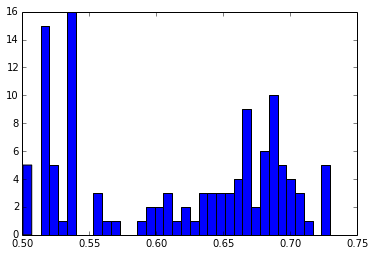

In [16]:
grid_values = map(lambda score_list: score_list.mean_validation_score, grid_search_cv.grid_scores_)
_=plt.hist(grid_values, bins=35)

NameError: name 'plot_decision_on_axes' is not defined

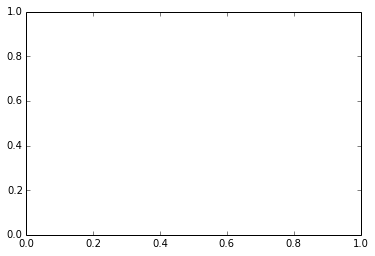

In [17]:
fig, ax = plt.subplots()
plot_decision_on_axes(grid_search_cv.best_estimator_, ax, line_features, line_labels)

## Regressor-based search
1. Fits a regressor on all evaluated points
2. Uses an optimization algorithm to find the extremum. Please note that REP operates on the grid points.
3. Evaluates cross-validation in the regressor extremum
4. GoTo 1

## Gaussian process
Fancy regressor - it can handle uncertainty.

In [3]:
# https://github.com/yandex/rep/blob/master/howto/03-howto-gridsearch.ipynb

A Gaussian process optimizer not stuck to the grid.
https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py

In [ ]:
from __future__ import print_function
from __future__ import division

from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization

# Load data set and target values
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=12,
                                   n_redundant=7)

def svccv(C, gamma):
    return cross_val_score(SVC(C=C, gamma=gamma, random_state=2),
                           data, target, 'f1', cv=5).mean()

def rfccv(n_estimators, min_samples_split, max_features):
    return cross_val_score(RFC(n_estimators=int(n_estimators),
                               min_samples_split=int(min_samples_split),
                               max_features=min(max_features, 0.999),
                               random_state=2),
                           data, target, 'f1', cv=5).mean()

if __name__ == "__main__":

    svcBO = BayesianOptimization(svccv, {'C': (0.001, 100), 'gamma': (0.0001, 0.1)})
    svcBO.explore({'C': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]})

    rfcBO = BayesianOptimization(rfccv, {'n_estimators': (10, 250),
                                         'min_samples_split': (2, 25),
                                         'max_features': (0.1, 0.999)})
    svcBO.maximize()

    print('-'*53)
    rfcBO.maximize()

    print('-'*53)
    print('Final Results')
    print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initializing function at point:  {'C': 0.001, 'gamma': 0.001} | result: 0.000000
Initializing function at point:  {'C': 0.01, 'gamma': 0.01} | result: 0.009555
Initializing function at point:  {'C': 0.1, 'gamma': 0.1} | result: 0.000000
Initializing function at point:  {'C': 4.5154968469486354, 'gamma': 0.021728284554773616} | result: 0.941686
Initializing function at point:  {'C': 49.24465270126823, 'gamma': 0.0067264875307147653} | result: 0.943655
Initializing function at point:  {'C': 95.754757521767274, 'gamma': 0.038553652526436992} | result: 0.914162
Initializing function at point:  {'C': 84.626173057479519, 'gamma': 0.081656605740562119} | result: 0.651125
Initializing function at point:  {'C': 47.88453162937946, 'gamma': 0.048562304553189557} | result: 0.874855
Iteration:   1 | Last sampled value:    0.705566 | with parameters:  {'C': 100.0, 'gamma': 0.077296206077338087}
               | Current maximum:       0.943655 | with parameters:  {'C': 49.24465270126823, 'gamma': 0.0

## Bonus (this time from me)
I've run gaussian-process paramenter optimization over the COMET data for GradientBoosting classifier, the data is available in the seminar folder. It took ~24 hours. See <git root>/day3/introductory_seminars/COMET_gradient_boosting_gauss_opt.csv

Note on the file: "loss" < 1 means 'deviance', and 'loss' >= 1 means 'exponential'.

SELF Use hyperparameter optimization to improve your Kaggle score.

# The code used for GP-optimization. It shouldn't run in the cloud.

In [7]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
import george
from george.kernels import ExpSquaredKernel
from scipy.stats import sem
from scipy import stats
from scipy.optimize import minimize

In [8]:
import numpy as np
def sample_points(boundaries, n_items):
    values = map(lambda boundary: np.random.uniform(boundary[0], boundary[1], size=n_items)[:, np.newaxis],
                boundaries)
    return np.concatenate(values, axis=1)

In [65]:
# https://github.com/Yelp/MOE/blob/master/moe_examples/combined_example.py
import numpy

from moe.easy_interface.experiment import Experiment
from moe.easy_interface.simple_endpoint import gp_next_points, gp_hyper_opt, gp_mean_var
from sklearn.grid_search import ParameterSampler
from collections import OrderedDict
from sklearn.base import clone
from scipy.stats import describe
from sklearn.cross_validation import cross_val_score

def moe_example(a, b):
    """Calculate an aribitrary 2-d function with some noise.

    This function has a minimum near [1, 2.6].
    """
    x = (a, b)
    return (numpy.sin(x[0]) * numpy.cos(x[1]) + numpy.cos(x[0] + x[1]) + numpy.random.uniform(-0.02, 0.02),
            0.2)

class HyperoptMOE(object):
    """Uses MOE to find the best hyperparameters."""
    
    def __init__(self, estimator, param_grid, param_types=None, num_to_sample=20,
                 bootstrap_num=10, verbose=False, **cv_parameters):
        """
        estiamtor - a sklearn estimator to optimize
        param_grid - a dict describing parameters. Format: {'param_name': [min, max]}.
        Supported types are anything, that can be transpaerntly converted to and from float.
        cv_parameters - parameters to pass to sklearn.cross_validation.cross_val_score
        """
        self.estimator = clone(estimator)
        self.param_grid = OrderedDict(param_grid.iteritems())
        self.param_types = param_types
        self.cv_parameters = cv_parameters
        self.bootstrap_num = bootstrap_num
        self.num_to_sample = num_to_sample
        self.verbose=verbose
        
    def fit(self, X, y):
        def moe_target(**parameters):
            if self.param_types:
                for name, type_ in self.param_types.iteritems():
                    parameters[name] = type_(parameters[name])
            parametrized_estimator = clone(self.estimator)
            parametrized_estimator.set_params(**parameters)
            cv_scores = cross_val_score(parametrized_estimator, X, y, **self.cv_parameters)
            return (-cv_scores.mean(), np.var(cv_scores))
        self.best_score_, self.best_params_, self.experiment = \
            bayes_optimize(moe_target, self.param_grid, self.num_to_sample,
                                          self.bootstrap_num, self.verbose)
        self.best_estimator_ = clone(self.estimator)
        self.best_estimator_.set_params(**self.best_params_)
        # For further analysis. To reestablish the relationship between 
        # columns in the experiment and parameter names, use param_grid
        return self.best_estimator_

def bayes_optimize(target_function, param_grid, num_to_sample=20, bootstrap_num=10, verbose=True):
    param_grid = OrderedDict(param_grid.iteritems())
    boundaries = param_grid.values()
    param_names = param_grid.keys()
    experiment = Experiment(boundaries)
    bootstrap_points = sample_points(boundaries, bootstrap_num)
    # Bootstrap with some known or already sampled point(s)
    # sampled points have the form [point_as_a_list, objective_function_value, value_variance]
    def call_target_with_positional_parameters(parameters):
        signature = dict(zip(param_names, parameters))
        return target_function(**signature)
    def bootstrap(point):
        function_value, function_variance = call_target_with_positional_parameters(point)
        return (point, function_value, function_variance)
    experiment.historical_data.append_sample_points(
            map(lambda point: bootstrap(point), bootstrap_points))

    # Sample points
    for i in range(num_to_sample):
        covariance_info = gp_hyper_opt(experiment.historical_data.to_list_of_sample_points())
        # Use MOE to determine what is the point with highest Expected Improvement to use next
        next_point_to_sample = gp_next_points(
                experiment,
                covariance_info=covariance_info,
                )[0]  # By default we only ask for one point
        # Sample the point from our objective function, we can replace this with any function
        value_of_next_point, variance_of_next_point  = call_target_with_positional_parameters(next_point_to_sample)

        if verbose:
            print "Sampled f({0:s}) = {1:.18E}".format(str(next_point_to_sample), value_of_next_point)

        # Add the information about the point to the experiment historical data to inform the GP
        experiment.historical_data.append_sample_points(
            [[next_point_to_sample, value_of_next_point, variance_of_next_point]])  # We can add some noise
    best_point_index = np.argmax(experiment.historical_data._points_sampled_value)
    return (experiment.historical_data._points_sampled_value[best_point_index],
            dict(zip(param_names, experiment.historical_data._points_sampled[best_point_index])),
            experiment)

In [38]:
bayes_optimize(moe_example, {'a': [0, 2], 'b': [0, 4]}, num_to_sample=5)

Updated covariance_info with {'hyperparameters': [0.695036841999, 2.0, 1.20826917785], 'covariance_type': u'square_exponential'}
Sampled f([0.712831935227, 2.6944051048]) = -1.542618111578802464E+00
Updated covariance_info with {'hyperparameters': [0.793093957492, 2.0, 1.24903559662], 'covariance_type': u'square_exponential'}
Sampled f([0.0, 3.05999722611]) = -9.915569240545721863E-01
Updated covariance_info with {'hyperparameters': [0.744723979817, 2.0, 1.23064379128], 'covariance_type': u'square_exponential'}
Sampled f([2.0, 2.46275723484]) = -9.714870284425362046E-01
Updated covariance_info with {'hyperparameters': [0.709395753796, 2.0, 1.22546198417], 'covariance_type': u'square_exponential'}
Sampled f([0.0, 4.0]) = -6.387004758993408693E-01
Updated covariance_info with {'hyperparameters': [0.667200775673, 2.0, 1.25249466202], 'covariance_type': u'square_exponential'}
Sampled f([0.0, 2.68272303962]) = -8.797188616600383204E-01


({'a': 0.3038053870245887, 'b': 0.16347446506591545},
 <moe.easy_interface.experiment.Experiment at 0x7feeb804b510>)

In [62]:
def get_categorical_map(values):
    def get_map(x):
        return values[int(x)]
    return get_map

In [73]:
moe_hcv_example = HyperoptMOE(GradientBoostingClassifier(),
                              param_grid={
                                  'loss': [0, 1.9999],
                                  'learning_rate': [1e-3, 1],
                                  'n_estimators': [10, 5e2],
                                  'max_depth': [1, 11]},
                              param_types={
                                'loss': get_categorical_map(('deviance', 'exponential')),
                                'n_estimators': int,
                                'max_depth': int}, 
                              verbose=True, num_to_sample=10,
                              cv=4, n_jobs=-1, scoring='roc_auc')

In [74]:
moe_hcv_example.fit(line_features, line_labels)

Sampled f([16.9042073337, 0.739700841289, 0.404749051509, 4.55673618668]) = -7.483333333333334059E-01
Sampled f([15.4618169617, 0.732872488586, 0.397474751269, 4.69026166881]) = -7.388888888888887063E-01
Sampled f([17.4744714896, 0.642538285241, 0.384189075209, 6.92951094636]) = -7.166666666666665630E-01
Sampled f([19.1108349978, 0.469230442039, 0.406660209505, 6.37123056711]) = -7.238888888888889150E-01
Sampled f([16.0684638591, 1.9999, 0.001, 4.38411208661]) = -5.949999999999999734E-01
Sampled f([18.7250349012, 1.57316506316, 1.0, 7.17073467732]) = -7.077777777777777279E-01
Sampled f([18.7602254897, 1.22486647354, 0.001, 7.41222597082]) = -6.416666666666666075E-01
Sampled f([17.7360448625, 0.382636573546, 1.0, 5.96493270597]) = -7.199999999999999734E-01
Sampled f([16.1073868116, 0.0, 0.001, 4.2726268765]) = -5.961111111111111471E-01
Sampled f([15.8124266162, 1.12524027204, 1.0, 4.03931996818]) = -7.299999999999999822E-01


GradientBoostingClassifier(init=None, learning_rate=0.001, loss=1.9999,
              max_depth=4.3841120866100001, max_features=None,
              max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=16.0684638591,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [75]:
print(moe_hcv_example.best_params_, moe_hcv_example.best_score_)

({'n_estimators': 16.0684638591, 'loss': 1.9999, 'learning_rate': 0.001, 'max_depth': 4.3841120866100001}, -0.59499999999999997)


Run on COMET. This might take a while...

In [77]:
moe_hcv_comet = HyperoptMOE(GradientBoostingClassifier(),
                              param_grid={
                                  'loss': [0, 1.9999],
                                  'learning_rate': [1e-3, 1],
                                  'n_estimators': [10, 5e2],
                                  'max_depth': [1, 11],
                                  'min_samples_split': [2, 20],
                                  'min_samples_leaf': [1, 10]},
                              param_types={
                                'loss': get_categorical_map(('deviance', 'exponential')),
                                'n_estimators': int,
                                'max_depth': int,
                                'min_samples_split': int,
                                'min_samples_leaf': int}, 
                              verbose=True, num_to_sample=40,
                              cv=4, n_jobs=-1, scoring='roc_auc')

In [ ]:
moe_hcv_comet.fit(comet_features, comet_labels)